In [1]:
import geopandas as gpd
import fiona

fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
geodata = gpd.read_file('chapter_12_data/chapter_12_data.kml')
geodata.head()


c:\Users\Administrator\PycharmProjects\env_py310\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Name description timestamp begin end altitudeMode  tessellate  extrude  \
0  Person 1        None       NaT   NaT NaT         None           1        0   
1  Person 2        None       NaT   NaT NaT         None           1        0   
2  Person 3        None       NaT   NaT NaT         None           1        0   

   visibility drawOrder  icon  \
0          -1      None  None   
1          -1      None  None   
2          -1      None  None   

                                            geometry  
0  LINESTRING Z (4.31777 50.86752 0.00000, 4.3180...  
1  LINESTRING Z (4.35425 50.86111 0.00000, 4.3542...  
2  LINESTRING Z (4.29375 50.83459 0.00000, 4.2947...

<AxesSubplot:>

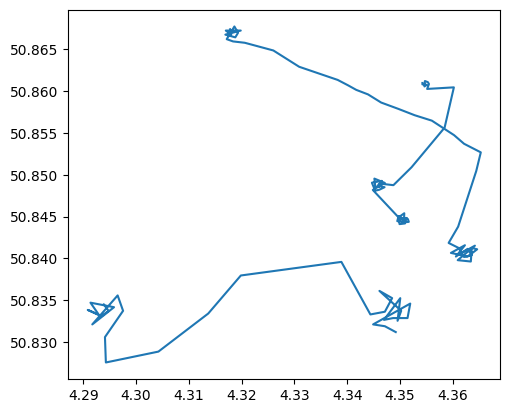

In [2]:
geodata.plot()

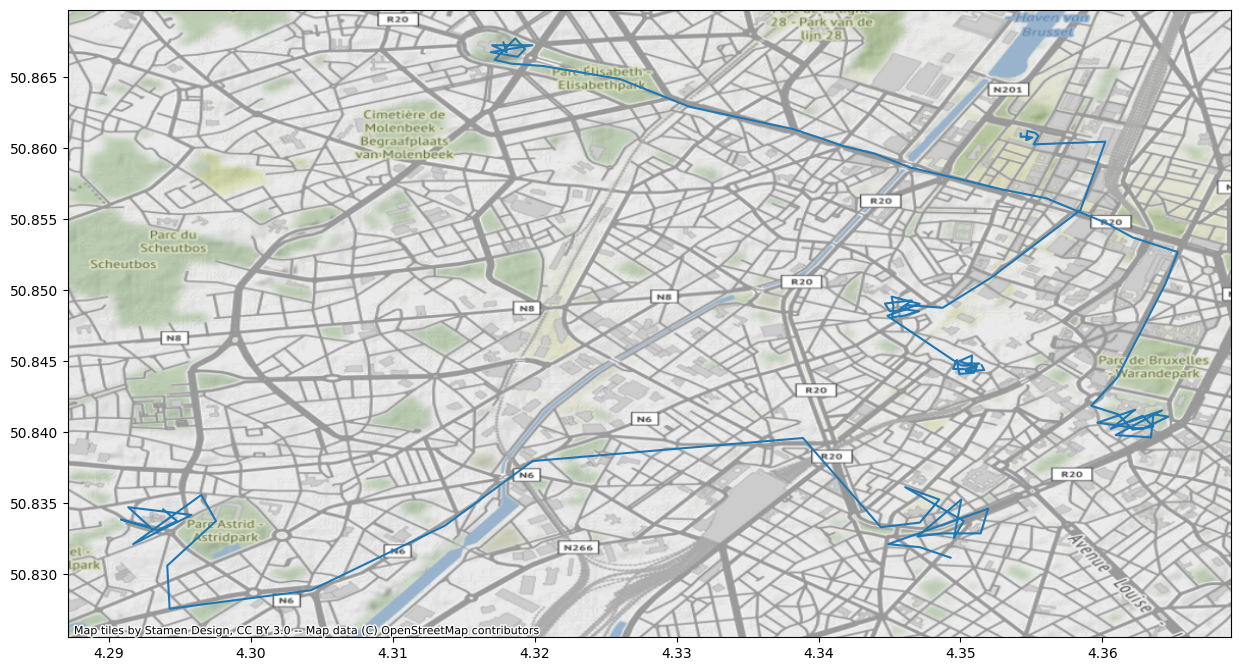

In [3]:
import contextily as cx
ax = geodata.plot(figsize=(15,15), markersize=64)
cx.add_basemap(ax, crs = geodata.crs)


In [4]:
#Let's start with finding POI of one person
one_person = geodata[geodata['Name'] =='Person 1']
one_person


Name description timestamp begin end altitudeMode  tessellate  extrude  \
0  Person 1        None       NaT   NaT NaT         None           1        0   

   visibility drawOrder  icon  \
0          -1      None  None   

                                            geometry  
0  LINESTRING Z (4.31777 50.86752 0.00000, 4.3180...

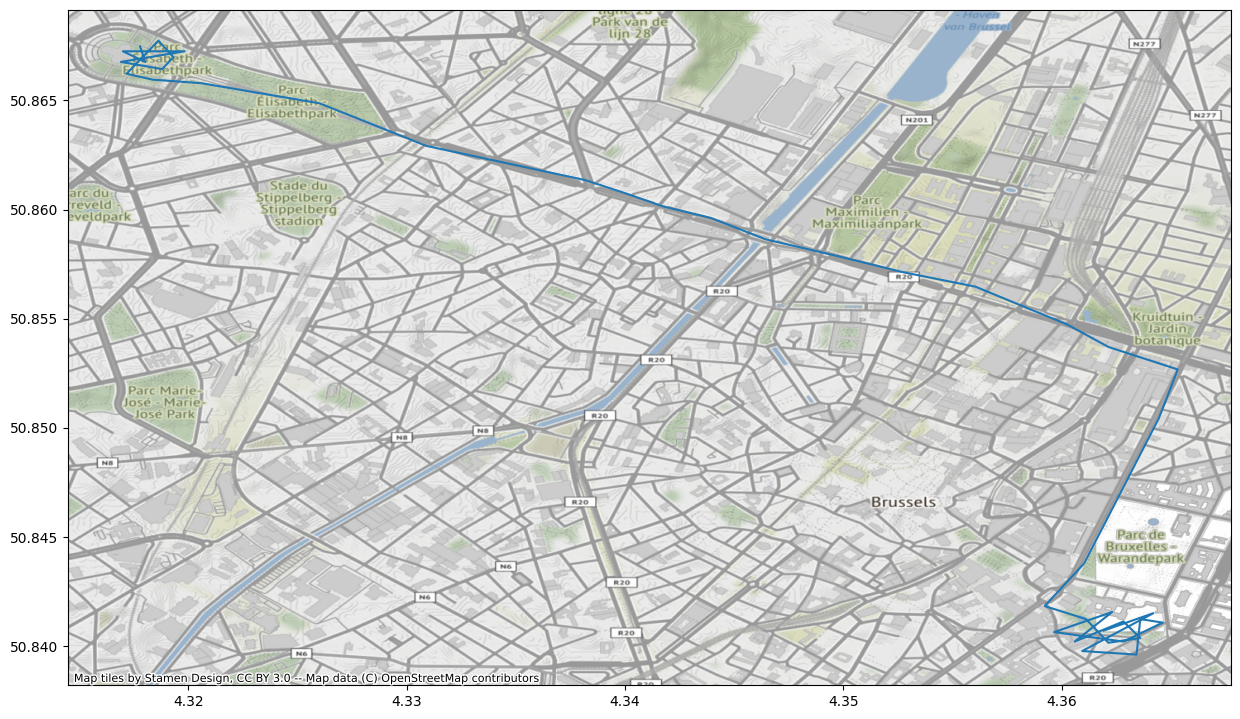

In [5]:
ax = one_person.plot(figsize=(15,15), markersize=64)
cx.add_basemap(ax, crs = one_person.crs)


In [6]:
import pandas as pd
one_person_points_df = pd.DataFrame(
    [x.strip('(').strip(')').strip('0').strip(' ').split(' ') 
    for x in str(one_person.loc[0, 'geometry'])[13:].split(',')],
    columns=['long','lat']
)
one_person_points_df = one_person_points_df.astype(float)
one_person_points_df.head()


long        lat
0  4.317766  50.867523
1  4.318023  50.866765
2  4.316993  50.867253
3  4.319826  50.867253
4  4.316908  50.866765

In [7]:
from sklearn.cluster import OPTICS
import numpy as np

clustering = OPTICS(metric='haversine')

one_person_points_df.loc[:,'cluster'] = clustering.fit_predict(np.radians(one_person_points_df[['lat', 'long']]))


In [8]:
one_person_points_df['cluster'].value_counts()

 0    13
 1    12
-1     9
 2     7
Name: cluster, dtype: int64

In [10]:
# remove all the observations with cluster -1 (outliers)
one_person_points_df = one_person_points_df[one_person_points_df['cluster'] != -1]


In [11]:
medians_of_POI = one_person_points_df.groupby(['cluster'])[['lat', 'long']].median().reset_index(drop=False)
medians_of_POI


cluster        lat      long
0        0  50.866765  4.318624
1        1  50.857501  4.351240
2        2  50.840377  4.362827

<AxesSubplot:>

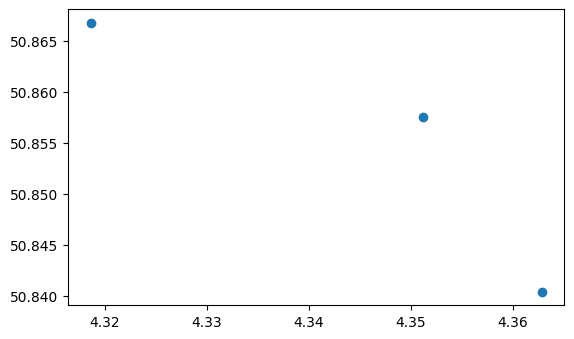

In [12]:
from shapely.geometry.point import Point
medians_of_POI_gdf = gpd.GeoDataFrame(medians_of_POI, geometry=[Point(x) for x in zip( list(medians_of_POI['long']), list(medians_of_POI['lat']))])
medians_of_POI_gdf.plot()


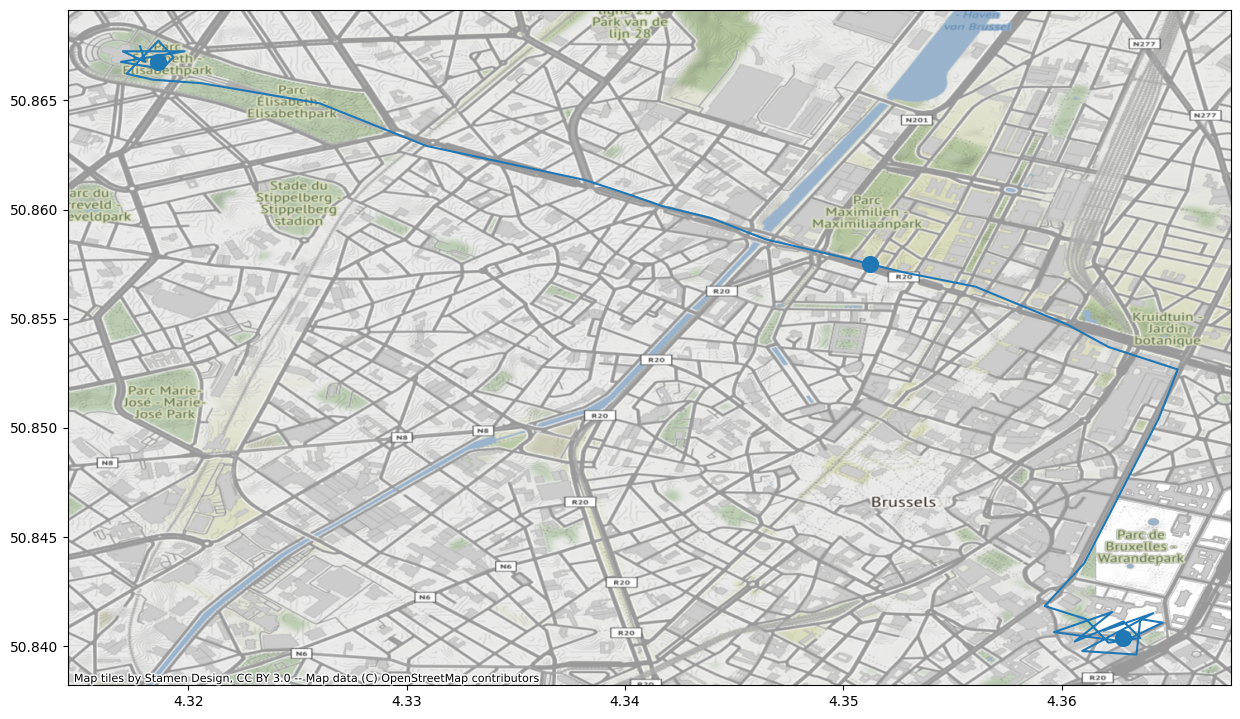

In [14]:
ax = one_person.plot(figsize=(15,15))
medians_of_POI_gdf.plot(ax=ax,markersize=128)
cx.add_basemap(ax, crs = one_person.crs)


   cluster        lat      long
0        0  50.866223  4.319311
1        1  50.841082  4.362312


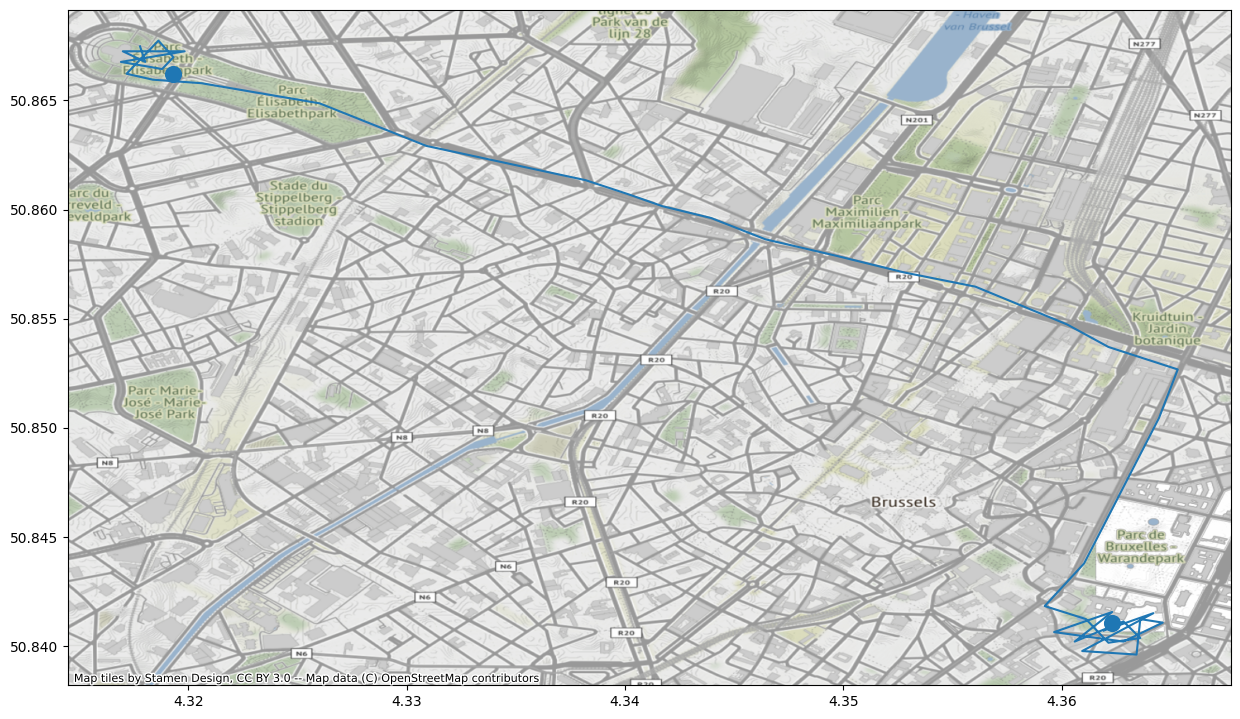

In [15]:
# try different settings
one_person_points_df = pd.DataFrame(
    [x.strip('(').strip(')').strip('0').strip(' ').split(' ') 
    for x in str(one_person.loc[0, 'geometry'])[13:].split(',')],
    columns=['long','lat']
)
one_person_points_df = one_person_points_df.astype(float)

clustering = OPTICS(min_samples = 10, max_eps=2.,min_cluster_size=8, xi = 0.05, metric='haversine')

one_person_points_df.loc[:,'cluster'] = clustering.fit_predict(np.radians(one_person_points_df[['lat', 'long']]))
one_person_points_df = one_person_points_df[one_person_points_df['cluster'] != -1]
medians_of_POI = one_person_points_df.groupby(['cluster'])[['lat', 'long']].median().reset_index(drop=False)

print(medians_of_POI)

medians_of_POI_gdf = gpd.GeoDataFrame(medians_of_POI, 
geometry=[Point(x) for x in zip( list(medians_of_POI['long']), list(medians_of_POI['lat']))])

ax = one_person.plot(figsize=(15,15))
medians_of_POI_gdf.plot(ax=ax,markersize=128)
cx.add_basemap(ax, crs = one_person.crs)



Name                                                     Person 1
description                                                  None
timestamp                                                     NaT
begin                                                         NaT
end                                                           NaT
altitudeMode                                                 None
tessellate                                                      1
extrude                                                         0
visibility                                                     -1
drawOrder                                                    None
icon                                                         None
geometry        LINESTRING Z (4.3177659 50.8675235 0, 4.318023...
Name: 0, dtype: object
   cluster        lat      long
0        0  50.866223  4.319311
1        1  50.841082  4.362312


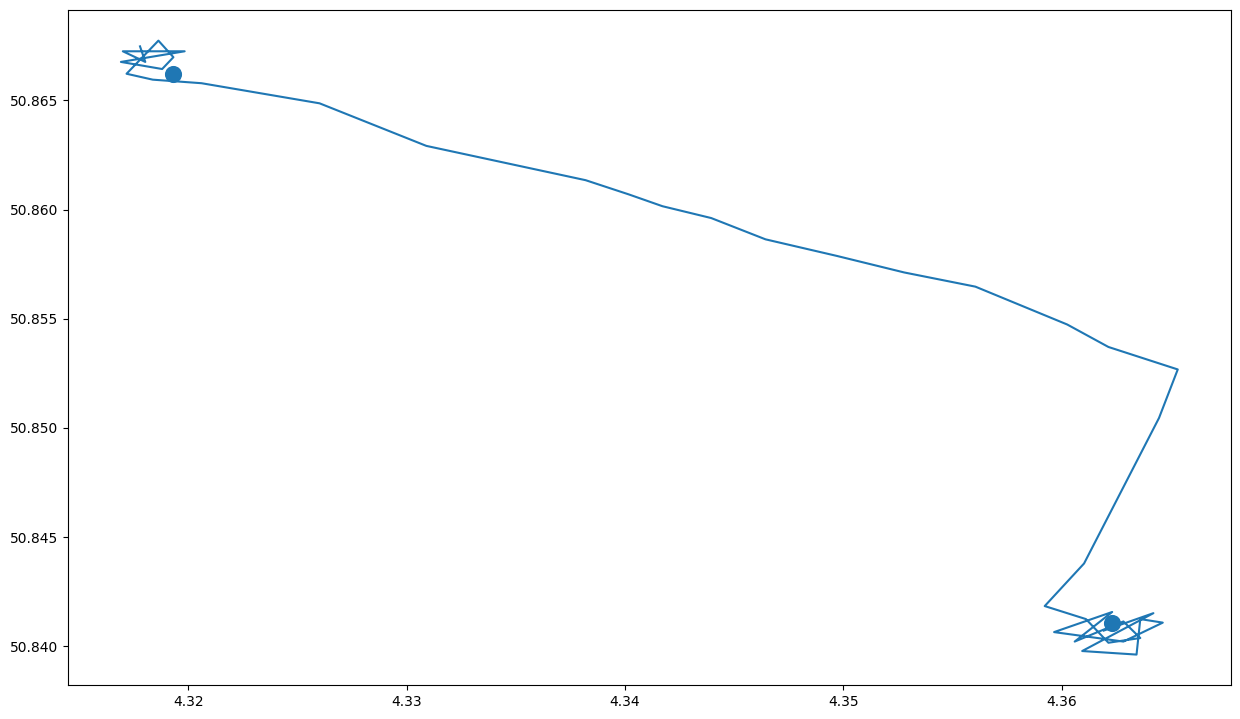

Name                                                     Person 2
description                                                  None
timestamp                                                     NaT
begin                                                         NaT
end                                                           NaT
altitudeMode                                                 None
tessellate                                                      1
extrude                                                         0
visibility                                                     -1
drawOrder                                                    None
icon                                                         None
geometry        LINESTRING Z (4.3542496 50.8611072 0, 4.354249...
Name: 1, dtype: object
   cluster        lat      long
0        0  50.860809  4.355065
1        1  50.848713  4.345924
2        2  50.844689  4.350430


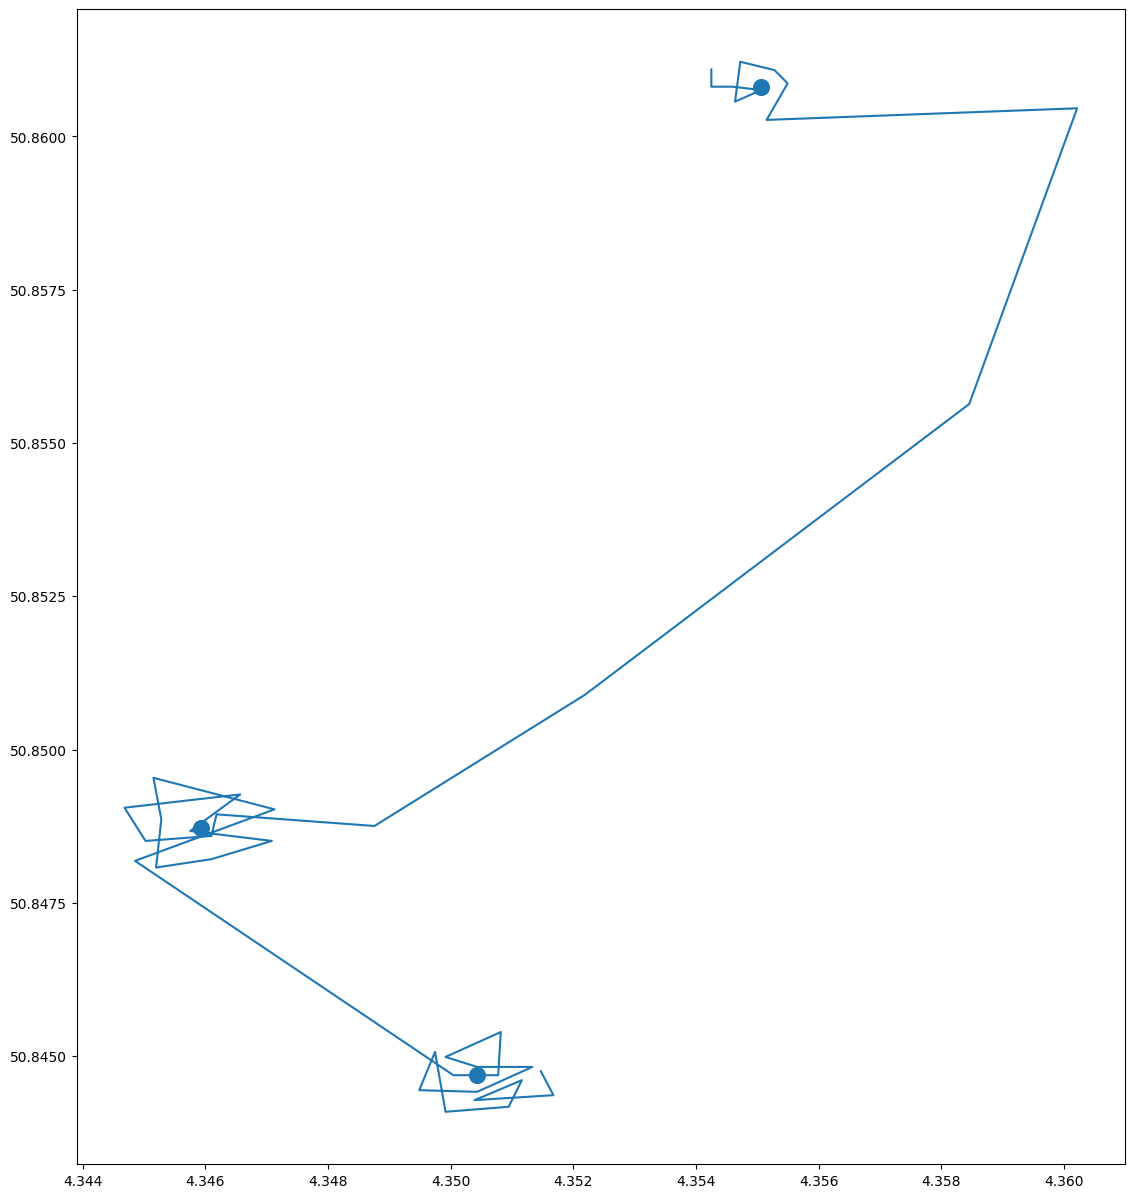

Name                                                     Person 3
description                                                  None
timestamp                                                     NaT
begin                                                         NaT
end                                                           NaT
altitudeMode                                                 None
tessellate                                                      1
extrude                                                         0
visibility                                                     -1
drawOrder                                                    None
icon                                                         None
geometry        LINESTRING Z (4.2937532 50.834587 0, 4.2947831...
Name: 2, dtype: object
   cluster        lat      long
0        0  50.833720  4.294268
1        1  50.833286  4.348513


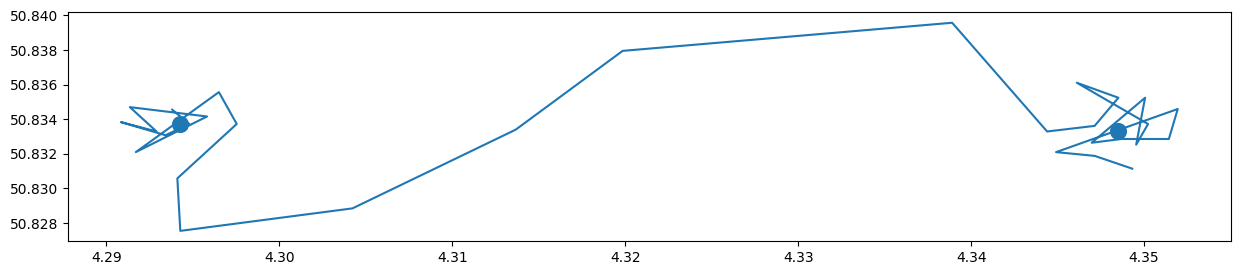

In [16]:
import matplotlib.pyplot as plt

for i,row in geodata.iterrows():
    print(row)
    one_person_points_df = pd.DataFrame(
    [x.strip('(').strip(')').strip('0').strip(' ').split(' ') 
    for x in str(row['geometry'])[13:].split(',')],
    columns=['long','lat']
    )
    one_person_points_df = one_person_points_df.astype(float)

    clustering = OPTICS(min_samples = 10, max_eps=2.,min_cluster_size=8, xi = 0.05, metric='haversine')

    one_person_points_df.loc[:,'cluster'] = clustering.fit_predict(np.radians(one_person_points_df[['lat', 'long']]))

    one_person_points_df =       one_person_points_df[one_person_points_df['cluster'] != -1]

    medians_of_POI = one_person_points_df.groupby(['cluster'])[['lat', 'long']].median().reset_index(drop=False)

    print(medians_of_POI)

    medians_of_POI_gdf = gpd.GeoDataFrame(medians_of_POI, geometry=[Point(x) for x in zip( list(medians_of_POI['long']), list(medians_of_POI['lat']))])

    ax = gpd.GeoDataFrame([row], geometry=[row['geometry']]).plot(figsize=(15,15))

    medians_of_POI_gdf.plot(ax=ax,markersize=128)
    plt.show()
